In [65]:
from typing import List, Union
from pydantic import BaseModel, conlist

In [ ]:
List[conlist(min_items=10, max_items=10)]

In [69]:
List[conlist(item_type=[[int,str,float]], min_items=10, max_items=10)]

typing.List[types.ConstrainedListValue]

# About Dataset
https://www.kaggle.com/code/coteli/house-rent-prediction-eda
## Context
Housing in India varies from palaces of erstwhile maharajas to modern apartment buildings in big cities to tiny huts in far-flung villages. There has been tremendous growth in India's housing sector as incomes have risen. The Human Rights Measurement Initiative finds that India is doing 60.9% of what should be possible at its level of income for the right to housing.

Renting, also known as hiring or letting, is an agreement where a payment is made for the temporary use of a good, service, or property owned by another. A gross lease is when the tenant pays a flat rental amount and the landlord pays for all property charges regularly incurred by the ownership. Renting can be an example of the sharing economy.

#### Content
In this Dataset, we have information on almost 4700+ Houses/Apartments/Flats Available for Rent with different parameters like BHK, Rent, Size, No. of Floors, Area Type, Area Locality, City, Furnishing Status, Type of Tenant Preferred, No. of Bathrooms, Point of Contact.

Dataset Glossary (Column-Wise)
- BHK: Number of Bedrooms, Hall, Kitchen.
- Rent: Rent of the Houses/Apartments/Flats.
- Size: Size of the Houses/Apartments/Flats in Square Feet.
- Floor: Houses/Apartments/Flats situated in which Floor and Total Number of Floors (Example: Ground out of 2, 3 out of 5, etc.)
- Area Type: Size of the Houses/Apartments/Flats calculated on either Super Area or Carpet Area or Build Area.
- Area Locality: Locality of the Houses/Apartments/Flats.
- City: City where the Houses/Apartments/Flats are Located.
- Furnishing Status: Furnishing Status of the Houses/Apartments/Flats, either it is Furnished or Semi-Furnished or Unfurnished.
- Tenant Preferred: Type of Tenant Preferred by the Owner or Agent.
- Bathroom: Number of Bathrooms.
- Point of Contact: Whom should you contact for more information regarding the Houses/Apartments/Flats.

# Load Data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_squared_error

from jcopml.tuning import random_search_params as rsp
from jcopml.feature_importance import mean_score_decrease
from jcopml.plot import plot_residual, plot_actual_vs_prediction, plot_roc_curve

In [3]:
df = pd.read_csv("House_Rent_Dataset.csv", parse_dates=["Posted On"])
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BHK,4746.0,2.083860,0.832256,1.0,2.0,2.0,3.0,6.0
Rent,4746.0,34993.451327,78106.412937,1200.0,10000.0,16000.0,33000.0,3500000.0
Size,4746.0,967.490729,634.202328,10.0,550.0,850.0,1200.0,8000.0
Bathroom,4746.0,1.965866,0.884532,1.0,1.0,2.0,2.0,10.0


### Desc Data

In [5]:
def data_desc(df):
    print ()
    print("Overall Data Description")
    print ("Total number of records", df.shape[0])
    print ("Total number of columns/features", df.shape[1])
    print ("")
    cols=df.columns
    data_type =[]
    for col in df.columns:
        data_type.append(df[col].dtype)
    n_uni = df.nunique()
    n_miss = df.isna().sum()
    names = list(zip(cols, data_type,n_uni,n_miss))
    variable_desc = pd.DataFrame(names,columns=["Name","Type","Unique levels","Missing"])
    print (variable_desc)

In [6]:
data_desc(df)


Overall Data Description
Total number of records 4746
Total number of columns/features 12

                 Name            Type  Unique levels  Missing
0           Posted On  datetime64[ns]             81        0
1                 BHK           int64              6        0
2                Rent           int64            243        0
3                Size           int64            615        0
4               Floor          object            480        0
5           Area Type          object              3        0
6       Area Locality          object           2235        0
7                City          object              6        0
8   Furnishing Status          object              3        0
9    Tenant Preferred          object              3        0
10           Bathroom           int64              8        0
11   Point of Contact          object              3        0


# Exploratory Data Analysis (EDA)

C:\Users\fahmi\AppData\Local\Temp\ipykernel_13412\621126171.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<AxesSubplot:>

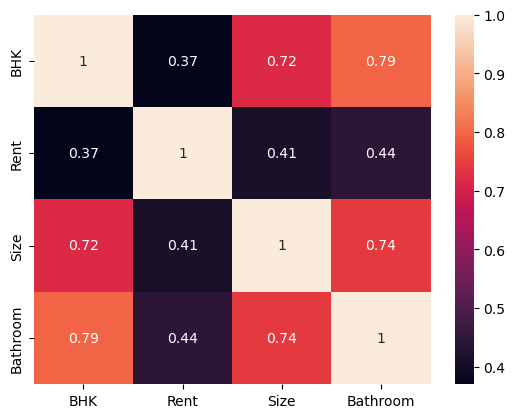

In [7]:
sns.heatmap(df.corr(), annot=True)

In [8]:
df.Floor.unique()

array(['Ground out of 2', '1 out of 3', '1 out of 2', 'Ground out of 1',
       'Ground out of 4', '1 out of 4', '1 out of 1', 'Ground out of 3',
       '2 out of 3', '4 out of 5', '2 out of 2', '2 out of 5',
       '4 out of 14', '3 out of 3', '5 out of 5', '4 out of 4',
       '7 out of 8', '2 out of 4', '3 out of 4', '1 out of 5',
       '8 out of 5', 'Ground out of 6', '2 out of 1',
       'Upper Basement out of 4', 'Ground out of 5', '3 out of 5',
       '11 out of 19', '5 out of 10', '11 out of 14',
       'Lower Basement out of 2', '2 out of 7', '4 out of 10',
       '7 out of 10', '2 out of 13', '6 out of 7', '4 out of 7',
       '14 out of 14', '43 out of 78', '2 out of 8', '13 out of 18',
       '5 out of 12', '18 out of 24', '3 out of 7', '17 out of 31',
       '11 out of 21', '7 out of 19', '14 out of 23', '9 out of 20',
       'Upper Basement out of 9', '19 out of 24', '3 out of 21',
       '1 out of 22', '8 out of 8', '6 out of 12', '4 out of 58',
       'Upper Basement o

In [9]:
df["Rental Floor"] = df["Floor"].apply(lambda x: x.split(" out of ")[0])
df["Total Number of Floor"] = df["Floor"].apply(lambda x: x.split(" out of ")[-1])
df.sample(5)

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor
1909,2022-05-23,1,6000,400,4 out of 5,Super Area,Kasturi Nagar,Bangalore,Semi-Furnished,Bachelors/Family,1,Contact Owner,4,5
2331,2022-05-05,3,42000,1880,14 out of 14,Super Area,whitefield,Bangalore,Semi-Furnished,Family,2,Contact Owner,14,14
728,2022-07-06,3,130000,1330,11 out of 51,Carpet Area,"Oberoi Esquire, Goregaon East",Mumbai,Semi-Furnished,Bachelors/Family,4,Contact Agent,11,51
138,2022-06-11,2,8500,1000,Ground out of 1,Carpet Area,South Baksara,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,Ground,1
864,2022-05-25,1,18500,430,5 out of 7,Carpet Area,"Gokul Accord, Thakur Complex",Mumbai,Unfurnished,Family,1,Contact Agent,5,7


In [10]:
df["Rental Floor"].unique()

array(['Ground', '1', '2', '4', '3', '5', '7', '8', 'Upper Basement',
       '11', 'Lower Basement', '6', '14', '43', '13', '18', '17', '9',
       '19', '60', '34', '12', '26', '25', '53', '16', '10', '39', '32',
       '47', '28', '20', '15', '65', '40', '37', '22', '21', '30', '35',
       '33', '44', '41', '46', '27', '45', '48', '50', '24', '23', '29',
       '49', '36', '76'], dtype=object)

In [11]:
df["Total Number of Floor"].unique()

array(['2', '3', '1', '4', '5', '14', '8', '6', '19', '10', '7', '13',
       '78', '18', '12', '24', '31', '21', '23', '20', '9', '22', '58',
       '16', '66', '48', '40', '44', '42', '41', '60', '32', '30', '29',
       '89', '15', '11', '28', '17', '45', '35', '75', '38', '51', '43',
       '25', '27', '26', '76', '36', '37', '55', '68', '77', '50', '59',
       '62', '39', '52', '54', '33', '46', '85', '71', '81', '34',
       'Ground'], dtype=object)

In [12]:
df["Rental Floor"] = df["Rental Floor"].replace(["Ground", "Upper Basement", "Lower Basement"], [0, -1, -2]).astype(int)
df["Total Number of Floor"] = df["Total Number of Floor"].replace("Ground", 0).astype(int)

In [13]:
df.drop(columns="Floor", inplace=True)
df.sample()

,Posted On,BHK,Rent,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor
4325,2022-06-06,3,14000,1400,Super Area,"Bolarum, Medchal Road",Hyderabad,Semi-Furnished,Bachelors/Family,2,Contact Owner,3,4


#### Floor Distribution

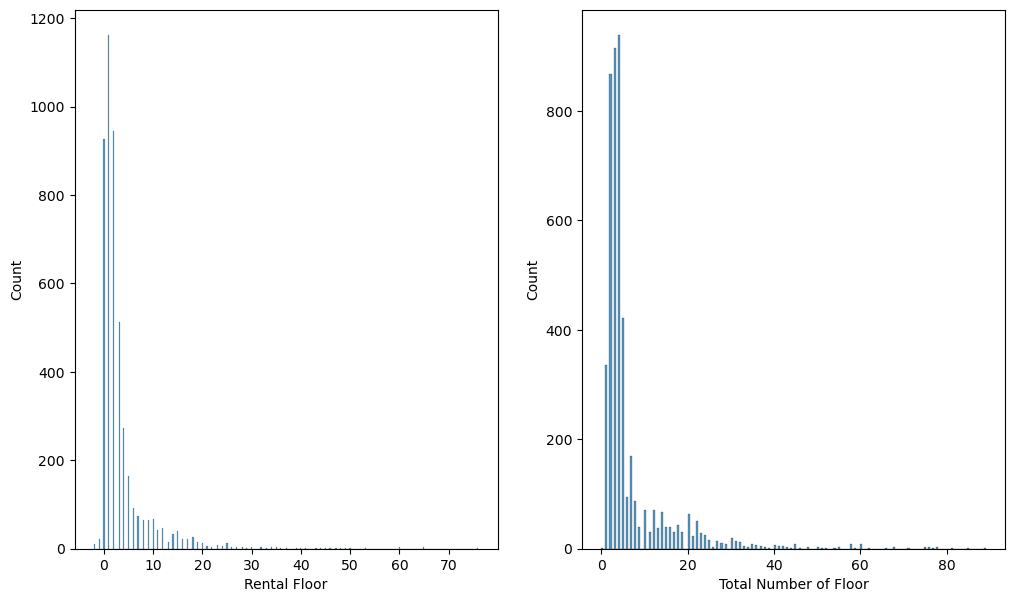

In [14]:
num_var = ["Rental Floor", "Total Number of Floor"]
fig, axes = plt.subplots(1, 2, figsize=(12,7))
for num, ax in zip(num_var, axes.flatten()):
    sns.histplot(x=num, data=df, ax=ax)

### Categorical variable

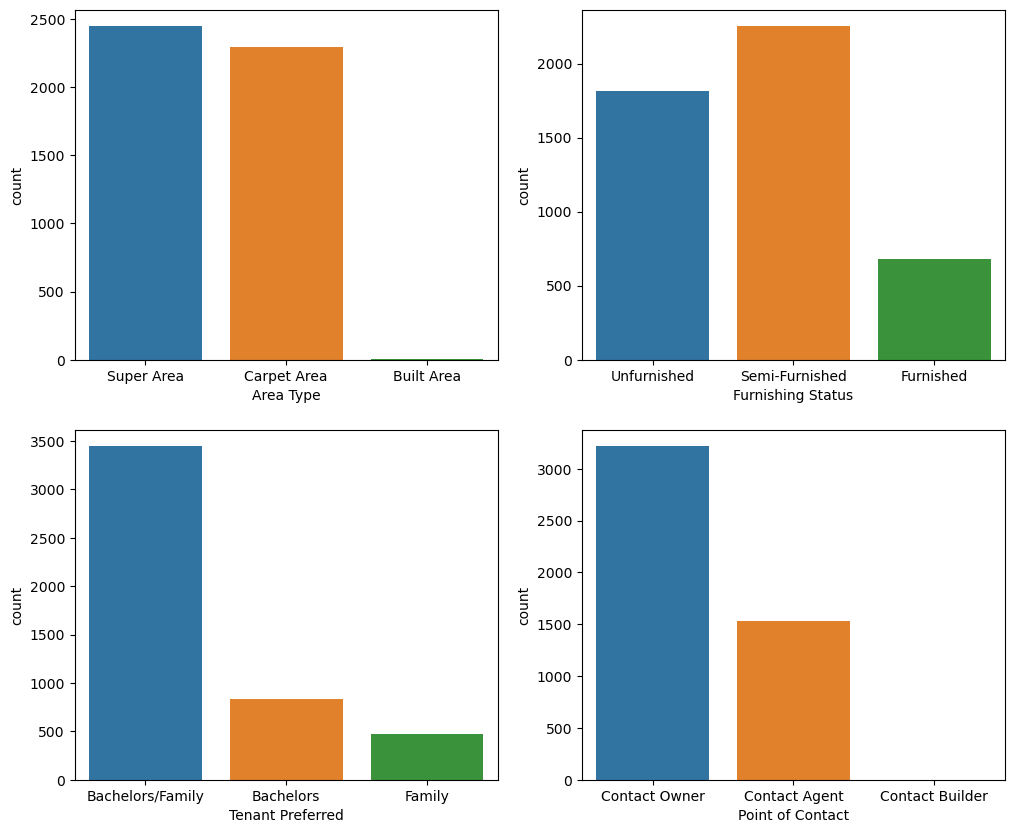

In [15]:
cat_var = ["Area Type", "Furnishing Status", "Tenant Preferred", "Point of Contact"]
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for cat, ax in zip(cat_var, axes.flatten()):
    sns.countplot(x=cat, data=df, ax=ax)

In [16]:
for col in df[["Area Type", "Point of Contact"]]:
    print(df[col].value_counts())
    print("="*35)

Super Area     2446
Carpet Area    2298
Built Area        2
Name: Area Type, dtype: int64
Contact Owner      3216
Contact Agent      1529
Contact Builder       1
Name: Point of Contact, dtype: int64


In the data set, three variables are defined as Area Types. These are the Super Area, the Carpet Area and the Build Area. Since Built Area and Super Area have a closer definition and the value of Built Area is only two, we can accept it as Super Area. Also in the Point of Contact column there are three variables and one of them has only one value. We can accept a Contact Author as a Contact Owner this way we can simplify data collection.

In [17]:
df.replace(to_replace=["Built Area", "Contact Builder"], 
           value=["Super Area", "Contact Owner"], inplace=True)

### Total Number of Rental in city

Text(0.5, 1.0, 'Total Number of Rental Houses in Cities')

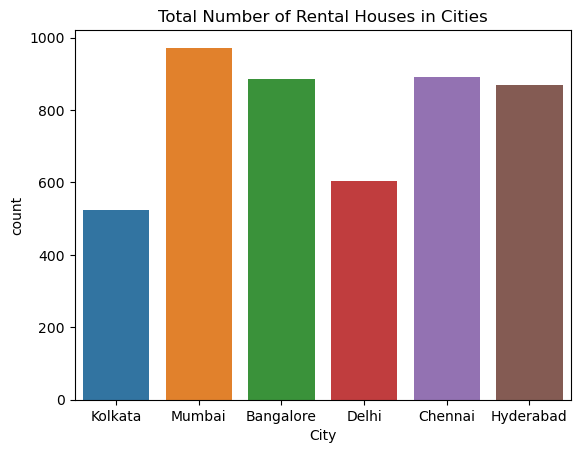

In [18]:
sns.countplot(x="City", data=df)
plt.title("Total Number of Rental Houses in Cities")

### Number of Room

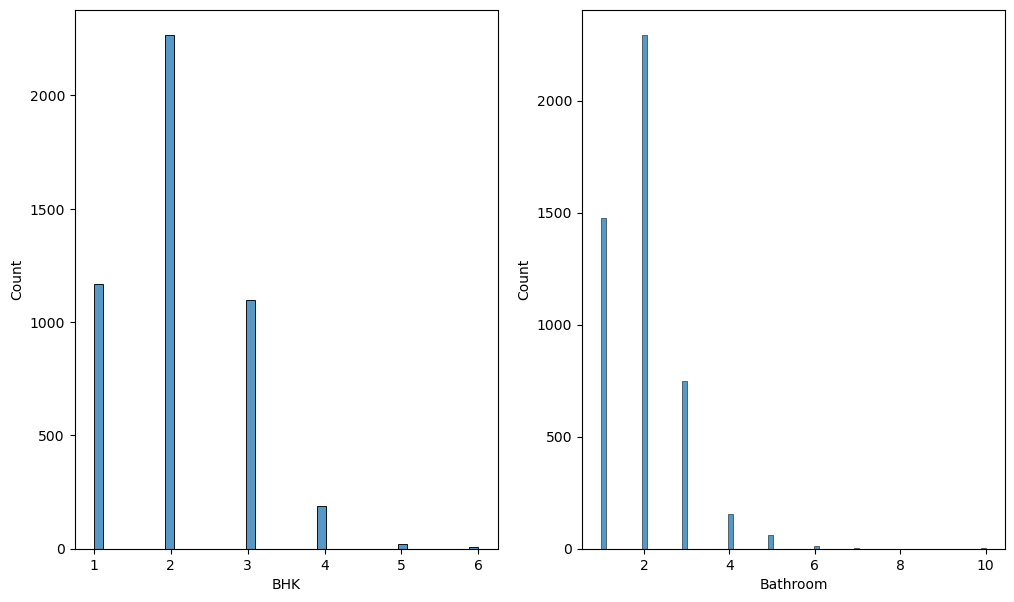

In [19]:
cat_var = ["BHK", "Bathroom"]
fig, axes = plt.subplots(1, 2, figsize=(12,7))
for cat, ax in zip(cat_var, axes.flatten()):
    sns.histplot(x=cat, data=df, ax=ax)

### Area multiple

In [20]:
area_mean = df.query("BHK + Bathroom == 4").groupby("Area Type", as_index=False).mean()
area_mean

C:\Users\fahmi\AppData\Local\Temp\ipykernel_13412\3345422993.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  area_mean = df.query("BHK + Bathroom == 4").groupby("Area Type", as_index=False).mean()


,Area Type,BHK,Rent,Size,Bathroom,Rental Floor,Total Number of Floor
0,Carpet Area,2.012484,34236.268414,838.001248,1.987516,4.308365,8.796504
1,Super Area,2.017787,15827.197628,933.087945,1.982213,1.777668,3.970356


In [21]:
carpet_area_size = area_mean.loc[0, "Size"]
super_area_size = area_mean.loc[1, "Size"]
area_per_multi = (super_area_size - carpet_area_size) / carpet_area_size + 1 #area prcentage multiplier

In [22]:
area_per_multi

1.1134684422029848

In [23]:
df["Fixed Size"] = df.query("`Area Type` == 'Carpet Area'")["Size"].apply(lambda x: x * area_per_multi)
df["Fixed Size"].fillna(df["Size"], inplace=True)

The basic unit of measurement in buying and renting real estate is the square foot rental price. Therefore areas of type 'Carpet Area' have been converted to type 'Super Area'. When performing this conversion, a multiplier created by dividing the difference in areas of similar house types is used.

In [24]:
df.head()

,Posted On,BHK,Rent,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor,Fixed Size
0,2022-05-18,2,10000,1100,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2,1100.000000
1,2022-05-13,2,20000,800,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,800.000000
2,2022-05-16,2,17000,1000,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,1000.000000
3,2022-07-04,2,10000,800,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1,2,800.000000
4,2022-05-09,2,7500,850,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,1,2,946.448176


In [25]:
df.drop(columns="Size", inplace=True)

### Time Effect

<AxesSubplot:xlabel='Posted On', ylabel='Rent'>

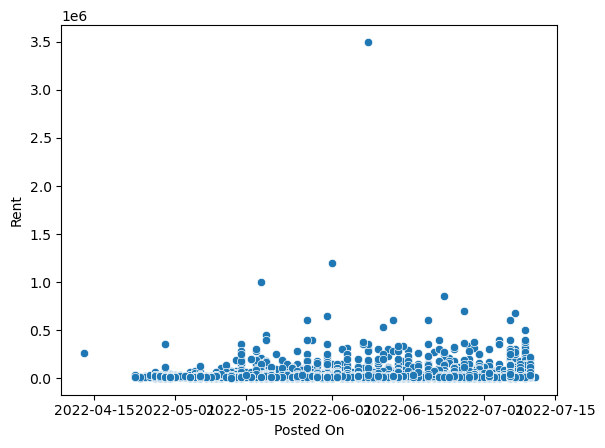

In [26]:
sns.scatterplot(x="Posted On", y="Rent", data=df)

### Target Distribution

<AxesSubplot:xlabel='Rent', ylabel='Count'>

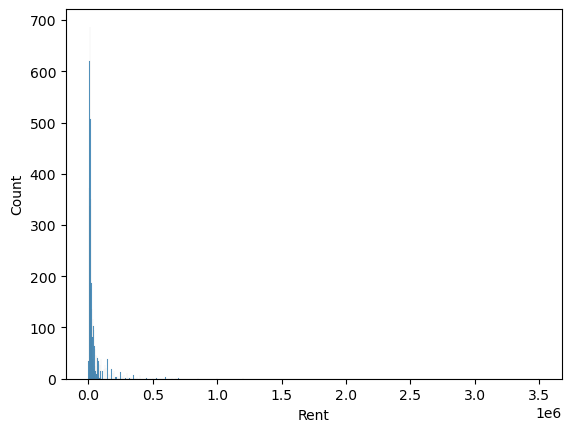

In [27]:
sns.histplot(x="Rent", data=df)

# Feature Engineering
### Handle Outlier

In [28]:
class Interval():
    
    def __init__(self, feature):
        self.mean = feature.mean()
        self.sd = feature.std()
        self.interval_range = [1.5, 2, 2.5, 3, 3.5, 4]
    
    def Upper_Interval(self):
        for interval in self.interval_range:
            upper_interval = self.mean + interval * self.sd
            upper_interval = np.round(upper_interval, 2)
            print(f"Upper Interval range {interval} : {upper_interval}")
            
    def Lower_Interval(self):
        for interval in self.interval_range:
            lower_interval = self.mean - interval * self.sd
            lower_interval = np.round(lower_interval, 2)
            print(f"Lower Interval range {interval} : {lower_interval}")
            
class Best_Interval(Interval):
    def __init__(self, feature):
        Interval.__init__(self, feature)

In [29]:
Best_Interval(df.Rent).Upper_Interval()

Upper Interval range 1.5 : 152153.07
Upper Interval range 2 : 191206.28
Upper Interval range 2.5 : 230259.48
Upper Interval range 3 : 269312.69
Upper Interval range 3.5 : 308365.9
Upper Interval range 4 : 347419.1


In [30]:
len(df.query("Rent > 152150"))

161

In [31]:
df = df.drop(df.query("Rent > 152150").index)

In [32]:
Best_Interval(df.Rent).Upper_Interval()

Upper Interval range 1.5 : 65470.08
Upper Interval range 2 : 78749.71
Upper Interval range 2.5 : 92029.35
Upper Interval range 3 : 105308.98
Upper Interval range 3.5 : 118588.61
Upper Interval range 4 : 131868.25


<AxesSubplot:xlabel='Rent', ylabel='Count'>

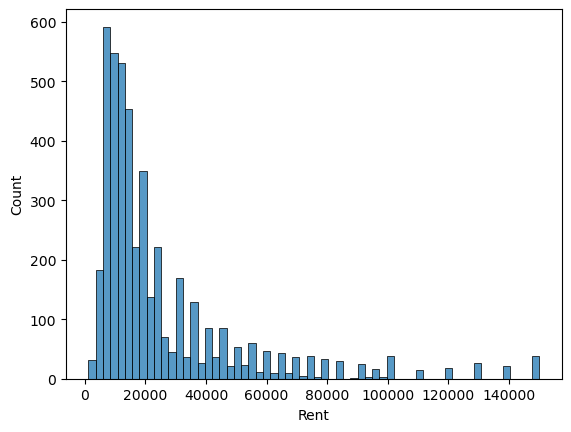

In [33]:
sns.histplot(x="Rent", data=df)

In [34]:
df.drop(columns =["Area Locality", "Posted On"], inplace = True)

# Build Model

## Baseline model

In [35]:
X = df.drop(columns='Rent')
y = df['Rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
X_train.shape, X_test.shape

((3438, 10), (1147, 10))

In [36]:
X_train.head()

,BHK,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor,Fixed Size
2193,3,Carpet Area,Bangalore,Semi-Furnished,Bachelors/Family,3,Contact Owner,18,19,2004.243196
3714,2,Super Area,Chennai,Unfurnished,Bachelors/Family,2,Contact Owner,0,2,685.000000
870,2,Carpet Area,Mumbai,Unfurnished,Bachelors/Family,2,Contact Agent,8,16,790.562594
511,3,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,3,Contact Owner,1,2,900.000000
3368,2,Carpet Area,Chennai,Unfurnished,Bachelors/Family,1,Contact Owner,0,2,779.427910


In [37]:
cat_pipe = Pipeline([("encode", OneHotEncoder(handle_unknown="ignore"))])
num_pipe = Pipeline([("scaler", StandardScaler())])

preprocessor = ColumnTransformer([
    ("numeric", num_pipe, [0,5,7,8,9]),
    ("categoric", cat_pipe, [1,2,3,4,6])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor())
])

# model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_jobs=-1, verbose=1, n_iter=100)
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

print(model.score(X_train,y_train), model.best_score_, model.score(X_test,y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'algo__colsample_bytree': 0.6751568368244592, 'algo__gamma': 1, 'algo__learning_rate': 0.06979881327268828, 'algo__max_depth': 10, 'algo__n_estimators': 162, 'algo__reg_alpha': 3.8625127718442127, 'algo__reg_lambda': 8.40927845540111, 'algo__subsample': 0.32102003515849653}
0.9041651749621856 0.7604335107135669 0.7834124957376531


In [38]:
pred = model.predict(X_test)
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))

RMSE: 11623.649125599326


#### Change Outlier with Interval

<AxesSubplot:xlabel='Rental Floor', ylabel='Count'>

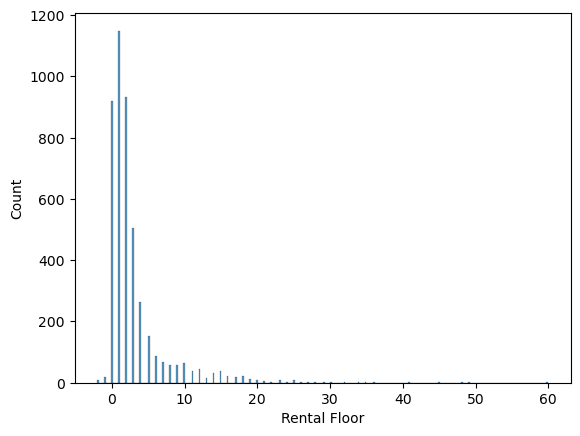

In [39]:
sns.histplot(x="Rental Floor", data=df)

#### Rental Floor

In [40]:
Best_Interval(df["Rental Floor"]).Upper_Interval()

Upper Interval range 1.5 : 10.11
Upper Interval range 2 : 12.46
Upper Interval range 2.5 : 14.8
Upper Interval range 3 : 17.15
Upper Interval range 3.5 : 19.5
Upper Interval range 4 : 21.84


In [41]:
len(df[df["Rental Floor"] > 22])

45

In [42]:
df["Rental Floor"] = np.where(df["Rental Floor"] > 22, 20, df["Rental Floor"])

#### Total of Number Floor

<AxesSubplot:xlabel='Total Number of Floor', ylabel='Count'>

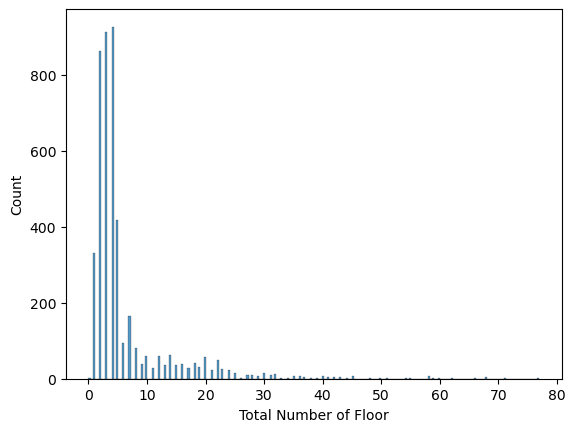

In [43]:
sns.histplot(x="Total Number of Floor", data=df)

In [44]:
Best_Interval(df["Total Number of Floor"]).Upper_Interval()

Upper Interval range 1.5 : 18.24
Upper Interval range 2 : 22.2
Upper Interval range 2.5 : 26.17
Upper Interval range 3 : 30.13
Upper Interval range 3.5 : 34.1
Upper Interval range 4 : 38.07


In [45]:
df["Total Number of Floor"] = np.where(df["Total Number of Floor"] > 30, 30, df["Total Number of Floor"])
df[["Total Number of Floor"]].head()

,Total Number of Floor
0,2
1,3
2,3
3,2
4,2


#### Fixed Size

<AxesSubplot:xlabel='Fixed Size', ylabel='Count'>

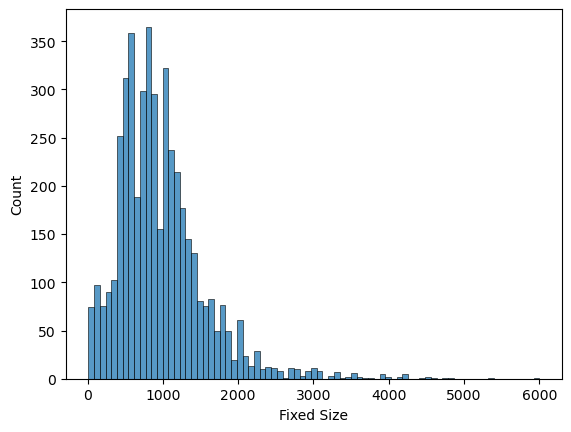

In [46]:
sns.histplot(x="Fixed Size", data=df)

In [47]:
len(df[df["Fixed Size"] > 3000])

59

In [48]:
df["Fixed Size"].mean()

974.0249864243535

In [49]:
Best_Interval(df["Fixed Size"]).Upper_Interval()

Upper Interval range 1.5 : 1871.57
Upper Interval range 2 : 2170.75
Upper Interval range 2.5 : 2469.94
Upper Interval range 3 : 2769.12
Upper Interval range 3.5 : 3068.3
Upper Interval range 4 : 3367.48


In [50]:
df["Fixed Size"] = np.where(df["Fixed Size"] > 3100, 3000, df["Fixed Size"])
df[["Fixed Size"]].head()

,Fixed Size
0,1100.000000
1,800.000000
2,1000.000000
3,800.000000
4,946.448176


In [51]:
df.head(2)

,BHK,Rent,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor,Fixed Size
0,2,10000,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2,1100.0
1,2,20000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,800.0


In [52]:
X = df.drop(columns='Rent')
y = df['Rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
X_train.shape, X_test.shape

((3438, 10), (1147, 10))

## Model Tuning

In [61]:
model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_jobs=-1, verbose=1, n_iter=50)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(model.best_params_)
print(model.score(X_train,y_train), model.best_score_, model.score(X_test,y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.8383462725280618, 'algo__gamma': 8, 'algo__learning_rate': 0.06454299140191229, 'algo__max_depth': 8, 'algo__n_estimators': 127, 'algo__reg_alpha': 0.0724540692891147, 'algo__reg_lambda': 6.729654336886433, 'algo__subsample': 0.35212847761475796}
0.8917379084984361 0.761155378160734 0.7729748616108831


In [62]:
print("Root mean squared error:")
print(np.sqrt(mean_squared_error(y_pred, y_test)))

Root mean squared error:
11900.433116379078


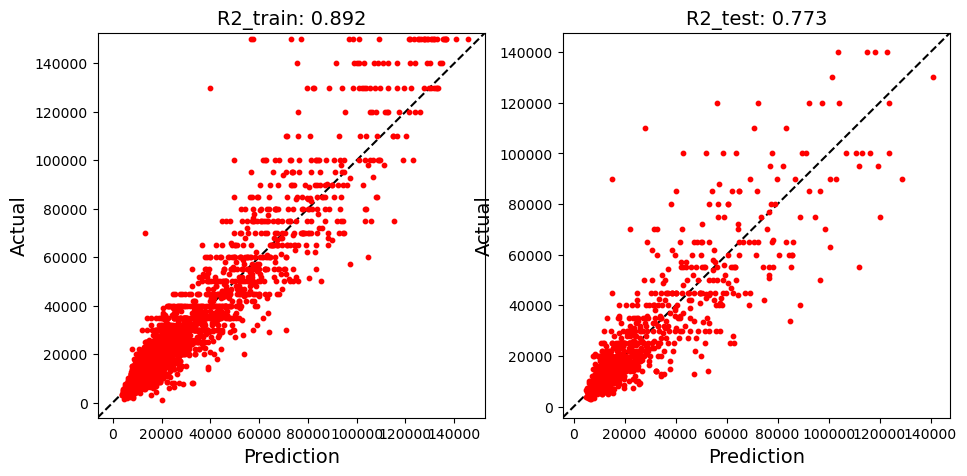

In [63]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

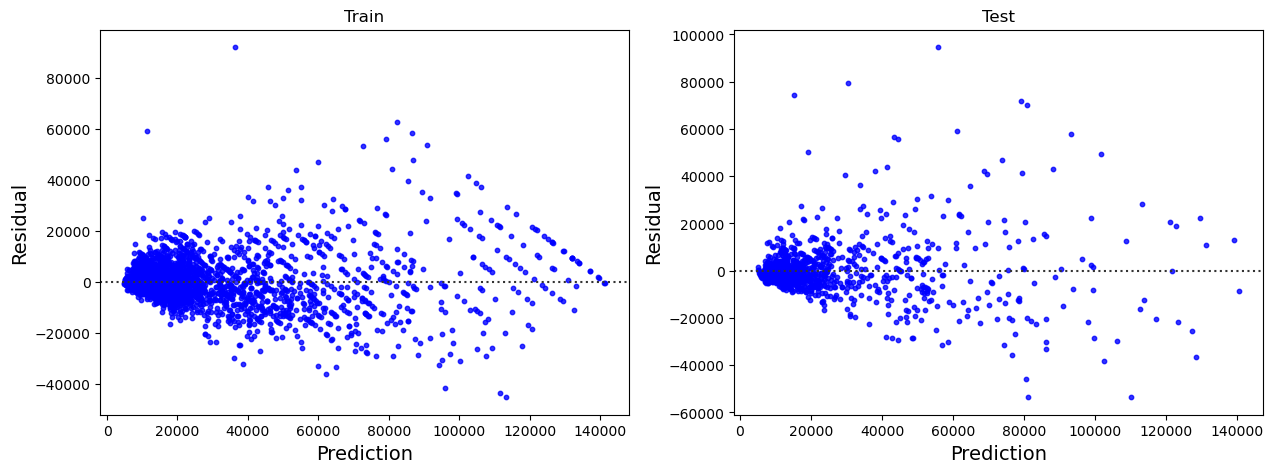

In [56]:
plot_residual(X_train, y_train, X_test, y_test, model, lowess=False)

## New Prediction

In [57]:
X_train.head(1)

,BHK,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor,Fixed Size
2193,3,Carpet Area,Bangalore,Semi-Furnished,Bachelors/Family,3,Contact Owner,18,19,2004.243196


In [58]:
y_train.head(1)

2193    28000
Name: Rent, dtype: int64

In [59]:
columns = X_train.columns
data = [[3, "Carpet Area", "Bangalore", "Semi-Furnished", "Bachelors/Family", 3, "Contact Owner", 18, 19, 2004.243196]]
data = pd.DataFrame(data=data, columns=columns)

pred = model.predict(data)
# pred = np.asarray(pred)
pred

array([32299.654], dtype=float32)

# Save model

In [60]:
import pickle


with open("final_model_v2.pkl", "wb") as f:
    pickle.dump(model, f)